In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib widget

In [2]:
data_uniform=np.load(r"C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic.npz",allow_pickle=True)
data_gauss=np.load(r"C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz",allow_pickle=True)
data_gauss_5=np.load(r"C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz",allow_pickle=True)

In [2]:
data_uniform=np.load(r"/Volumes/KINGSTON/Synthetic_data_no_defect/2025_10_24_sample_100x100x5mm_no_defect_isotropic.npz",allow_pickle=True)
data_gauss=np.load(r"/Volumes/KINGSTON/Synthetic_data_no_defect/2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz",allow_pickle=True)
data_gauss_5=np.load(r"/Volumes/KINGSTON/Synthetic_data_no_defect/2025_11_18_sample_100x100x5mm_no_defect_isotropic_gaussian_heat_no_conv_cond_5.npz",allow_pickle=True)

In [3]:
data_uniform['meta']

array([['time', '24/10/2025 20:16:11'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '300'],
       ['T2_units', 'frames'],
       ['T3', '3000'],
       ['T3_units', 'frames'],
       ['fps', '300.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '3304'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.005'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '2.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J

In [4]:
ccase=torch.from_numpy(data_uniform['data']).to(torch.float32)

In [5]:
ccase.size()

torch.Size([3304, 512, 512])

In [83]:
class DataGenerator:
    def __init__(self,data):
        """
        Constructor of data generot class
        data: torch tensor of shape (T,size_y,size_x) !Must be Normalized between 0 and 1 

        """
        self.data=data
    
    def get_indexes_latin(self, n_points):
        """
        Generate n_points unique 2D integer indices on a grid (size_y, size_x)
        using true stratified sampling (2D Latin Hypercube style),
        strictly inside the boundaries (not touching edges).
        """

        size_y = self.data.size(1)
        size_x = self.data.size(2)

        # Determine number of strata along each axis (roughly square)
        n_sqrt = int(torch.ceil(torch.sqrt(torch.tensor(n_points, dtype=torch.float32))))
        n_y = min(n_sqrt, size_y - 2)  # leave 1 pixel margin
        n_x = min(int(torch.ceil(torch.tensor(n_points, dtype=torch.float32) / n_y)), size_x - 2)

        # Compute stratum edges (avoid touching boundaries)
        y_edges = torch.linspace(1, size_y - 1, n_y + 1)
        x_edges = torch.linspace(1, size_x - 1, n_x + 1)

        points = []
        for i in range(n_y):
            for j in range(n_x):
                if len(points) >= n_points:
                    break

                # Pick a random point inside the stratum
                y = torch.randint(int(y_edges[i]), int(y_edges[i + 1]), (1,)).item()
                x = torch.randint(int(x_edges[j]), int(x_edges[j + 1]), (1,)).item()

                points.append((y, x))

        # Convert to tensors
        points = torch.tensor(points[:n_points])
        Y, X = points[:, 0], points[:, 1]

        return X, Y

    
    def sub_sample(self,X,Y,sub_sample=1,frame_rate=300):
        T=self.data.size(0)
        temp=self.data[::sub_sample,Y,X]
        temp_len=temp.size(0)
        t_v=torch.linspace(0,T/frame_rate,temp_len) # This produce for us only physical scale of time
        return temp, t_v
    
    def network_format(self,n_points,sub_sample=1,frame_rate=300,phys_scale=0.1):
        # 1. Get the sample points
        X, Y = self.get_indexes_latin(n_points)

        # 2. Sample the data
        temp, t_v = self.sub_sample(X, Y, sub_sample, frame_rate)  # temp shape: (T, n_points)
        
        # 3. Convert indices to physical units for network 
        
        # Debugging line
        # Yf = Y.to(torch.float32)
        # Xf = X.to(torch.float32)
        
        _,N_y,N_x=self.data.size()
        Yf = Y*phys_scale/N_y
        Xf = X*phys_scale/N_x

        # 4. Use meshgrid over time and point index
        point_idx = torch.arange(n_points).to(torch.float32)
        
        # Debugging line
        # t_v=torch.linspace(0,3304,3304)

        Tt, P = torch.meshgrid(t_v, point_idx, indexing='ij')  # shape: (T, n_points)
        P = P.to(torch.long)  # index must be integer

        # 5. Gather corresponding Y, X for each point
        Yy = Yf[P]  # shape: (T, n_points)
        Xx = Xf[P]  # shape: (T, n_points)

        # 6. Flatten in row-major order to match temp.flatten()
        Tt = Tt.reshape(-1, 1)
        Yy = Yy.reshape(-1, 1)
        Xx = Xx.reshape(-1, 1)
        Zz = torch.zeros_like(Xx)

        # 7. Network input
        X_net = torch.cat([Tt, Yy, Xx, Zz], dim=1)

        # 8. Flatten target in **same order**
        Y_net = temp.reshape(-1, 1)


        # Our X_net data are in physical unit sense
        return X_net, Y_net

    def boundary_data(self,boundary_division=4,sub_sample=1,frame_rate=300,phys_scale=0.1):
        
        # 1. Generate boundary points
        _,size_y,size_x=self.data.size()
        x=torch.linspace(0,size_x-1,boundary_division)
        y=torch.linspace(0,size_y-1,boundary_division)

        P_lr=torch.ones(2*boundary_division,2)*(size_x-1)
        P_lr[0:boundary_division,0]=0.0
        j=0
        for i in range(2*boundary_division):
            if j==boundary_division:
                j=0
            P_lr[i,1]=x[j]
            j=j+1

        P_tb=torch.ones(2*boundary_division,2)*(size_y-1)
        P_tb[0:boundary_division,1]=0.0

        j=0
        for i in range(2*boundary_division):
            if j==boundary_division:
                j=0
            P_tb[i,0]=y[j]
            j=j+1

        P=torch.concatenate([P_lr,P_tb],dim=0)
        P=P.round().long()

        Px=P[:,0]
        Py=P[:,1]

        # 2. Sample data temporal values
        temp_boundary,t_v=self.sub_sample(Px,Py,sub_sample=sub_sample,frame_rate=frame_rate)

        # 3. Convert indices to physical units for network
        Px=Px*phys_scale/size_x
        Py=Py*phys_scale/size_y

        point_idx = torch.arange(Px.size(0)).to(torch.float32)
        
        Tt, Point = torch.meshgrid(t_v, point_idx, indexing='ij')  # shape: (T, n_points)
        Point = Point.to(torch.long)  # index must be integer

        # 5. Gather corresponding Y, X for each point
        Yy = Py[Point]  # shape: (T, n_points)
        Xx = Px[Point]  # shape: (T, n_points)

        # 6. Flatten in row-major order to match temp.flatten()
        Tt = Tt.reshape(-1, 1)
        Yy = Yy.reshape(-1, 1)
        Xx = Xx.reshape(-1, 1)
        Zz = torch.zeros_like(Xx)

        # 7. Network input
        X_net = torch.cat([Tt, Yy, Xx, Zz], dim=1)

        # 8. Flatten target in **same order**
        Y_net = temp_boundary.reshape(-1, 1)

        return X_net, Y_net
    
    def lhs(self,n_samples, n_dims):
        """
        Latin Hypercube Sampling in [0,1]^n_dims.
        Returns tensor of shape (n_samples, n_dims).
        """
        # Divide into equal strata
        cut = torch.linspace(0, 1, n_samples + 1)

        # Sample one point uniformly from each stratum per dimension
        u = torch.rand(n_samples, n_dims)
        samples = cut[:-1].unsqueeze(1) + (u * (1.0 / n_samples))

        # Shuffle within each dimension
        for dim in range(n_dims):
            perm = torch.randperm(n_samples)
            samples[:, dim] = samples[perm, dim]

        return samples
    
    def set_initial_condition_points(self,n_points,phys_scales=[0.1,0.1,0.005]):

        X = self.lhs(n_samples=n_points, n_dims=3)
        phys_scales=torch.tensor(phys_scales)
        X_phys=X*phys_scales

        time_axis=torch.zeros((n_points,1))
        X_net=torch.concatenate([time_axis,X_phys],dim=1)

        Y_net=torch.zeros((n_points,1))

        return X_net, Y_net
    
    def set_collocation_points(self,N_t,N_space,phys_scales=[14.0,0.1,0.1,0.005]):
        
        phys_scales = torch.tensor(phys_scales)

        # Time points (flattened)
        time_axis = self.lhs(n_samples=N_t, n_dims=1).flatten() * phys_scales[0]

        # Space points (same for all times)
        space_points = self.lhs(n_samples=N_space, n_dims=3) * phys_scales[1:4]

        # Allocate collocation array
        X = torch.zeros((N_t * N_space, 4))

        for i, t in enumerate(time_axis):
            X[N_space*i:N_space*(i+1), 0] = t        # time
            X[N_space*i:N_space*(i+1), 1:4] = space_points  # x, y, z

        return X

In [84]:
operator=DataGenerator(ccase)

In [88]:
X=operator.set_collocation_points(N_t=100,N_space=1000)

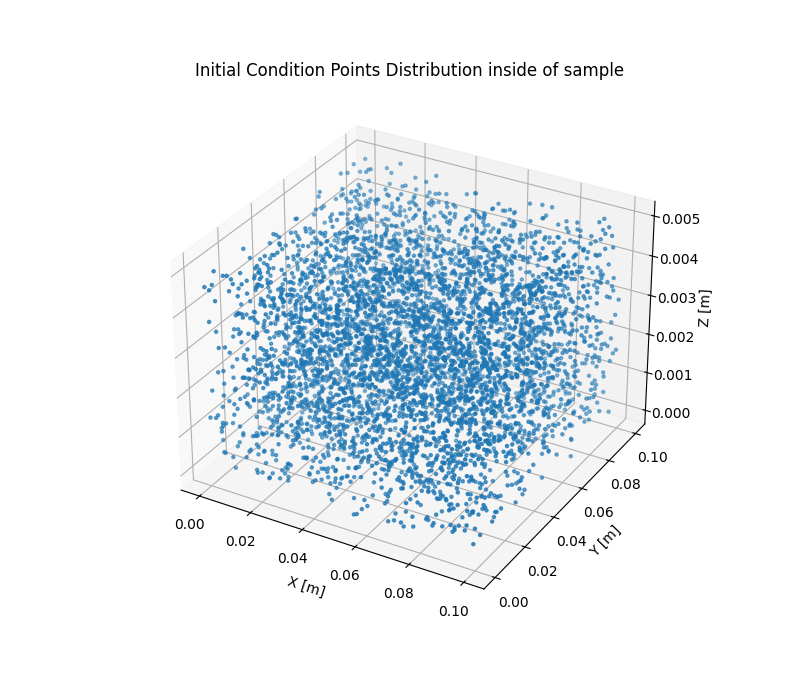

In [57]:
# exaggerate Z only for visualization

pts_viz = X[:,1:] 

fig = plt.figure(figsize=(8,7))
plt.tight_layout()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pts_viz[:,0], pts_viz[:,1], pts_viz[:,2], s=5)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
plt.title("Initial Condition Points Distribution inside of sample")
plt.show()